# Calculation of N14 A$\beta$ concentration using N15 labeled A$\beta$ and MALDI-MS

To do:
* document all the code
* ~document with markdown around the code~
* ~save the processed data~
* maybe some extra controls?
* ~make composite plot of all peaks~
* fix styling of plots
* Get a DOI
* insert some references
* Find stackoverflow answer to give cred? or modify enough to not need it?
* Generate an environment file.

## Abstract
Alzheimer's Disease (AD) is already a huge problem in today's society and is projected to become even worse in near future. A hallmark of AD is the formation of amyloid plaques, these mainly consist of a protein called amyloid beta (a.k.a. abeta or A$\beta$). Much is still unkown about the formation of these plaques, both in terms of cause and mechanism. To help elucidate answers in these questions I'm studying the solubility of abeta, i.e. at what concentration does this protein aggregate and what intrinsic and extrinsic factors modulate this? An essential part of this is of course quantifying the concentration of abeta under different conditions but quantifying protein concentrations can be hard. As abeta doesn't contain any tryptophans and only 1 tyrosine, concentration determination by absorbance only works at quite high concentrations. Thus another method is needed, here I utilize matrix-assisted laser desorption ionization mass spectroscopy (MALDI-MS) to get a ratio of peak intensities from abeta and a chemically identical version of abeta with an extra neutron that I have added to the sample at a known concentration. As these N14 abeta peptides and N15 abeta peptides are chemically identical they will ionize equally in MS but the extra neutron will separate them and the ratio of peak intensities will be equal to the concentration ratio between them. As this quickly becomes very tedious work for many samples this notebook automates the process by reading in peak intensities from exported excel files, matching them to correct cleavage product froms protease digestion, pairs corrseponding N14 and N15 peaks, divides them with each other generating ratios, sorts these by user defined indices and finally plots the results. As example data the adsorption of abeta to pipette tips is used.

## Import packages & data


In [1]:
import pandas as pd #for data handling
import matplotlib.pyplot as plt #for plotting
#import matplotlib  #for dev
import string #for generating well names
#import numpy as np #needed?

In [2]:
list_of_data = pd.read_excel('masslist.xlsx', sheet_name=None, header=2) #create a dictionary of pandas dataframes with each data frame corresponding to a sheet in the excel file.


## Define peaks of interest
Here is peak lists for A$\beta_{m1-42}$ digested with either AspN or trypsin.

In [3]:
#ABm1_42_aspN_N14_peaks = [905.39,1905.91]
#ABm1_42_aspN_N15_peaks = [917.36,1927.85]

ABm1_42_tryp_N14_peaks = [768.33,1325.67,1336.60]
ABm1_42_tryp_N15_peaks = [777.31,1339.63,1355.55]

## Define the main function
This function is what finds the relevant peaks based on above lists and a fault tolerance of m/z values. It then finds associated isotope peaks as which are + or - increments of 1 Da from the theoretical peaks as you have a natural isotope distribution (some carbons will be C13 and depending on how many the peak will come at another m/z value). It then sums up all the intensities for each of the peaks in the isotope pattern and divides the sum for N14 by that for N15 for each of the peaks defined above. Also indexes the generated list by well name and peak (based on N14 peaks and without decimals so the peaks are called 768, 1325 and 1336 in this case)

In [4]:
def ratio_maker2(input_data,n14_peaks,n15_peaks,fault_tolerance):   #for ratios of all isotope peaks summed.
    n14=n14_peaks
    n15=n15_peaks
    values=[] # this list will gather all calculated ratios as the for loop below works through the sheets in the input data.
    index_list=[] # this will simultanously as the above gather well name and peak number to keep track on what ratios belong to what.
    all_N14 = {} # this collects all isotope peaks used for the sums (and by extension the ratios)
    all_N15 = {} # same as above 
    for x in input_data.keys():        
        df=input_data[x] # define the current dataframe as df for convenience 
        for i in range(len(n14)):
            tmp = df.loc[((df["m/z"]>(n14[i]-fault_tolerance)) & (df["m/z"]<(n14[i]+fault_tolerance)) |
               (df["m/z"]>(n15[i]-fault_tolerance)) & (df["m/z"]<(n15[i]+fault_tolerance))), ] 
            #makes a dataframe with only the peaks from masslist.xlsx that are within the fault tolerance from the theoretical cleavage peaks
            if len(tmp) > 2:
                tmp=tmp.sort_values('SN',ascending=False).iloc[0:2]
                # sometimes there is extra peaks very close to the ones of interest so this hopefully removes them
                # by only keeping the 2 with highest signal to noise ratio 
            if len(tmp) == 2:
                n14_isotopes= []
                # If tmp is exactly 2 rows long then we should only have the main N14 and N15 peak           
                n14_isotopes.append(df.loc[((df["m/z"]>(n14[i]-fault_tolerance)) & (df["m/z"]<(n14[i]+fault_tolerance))),])
                # we then add the peak that are 1 +- 0.1 Da heavier then the main N14 peak and then the one 1 Da heavier then that one and so on 
                # until there is no more peaks that are 1 +- 0.1 Da heavier. This collects all the isotope peaks to the right of the main peak. 
                a=1
                while (not df.loc[((df["m/z"]>(tmp.iloc[0]['m/z']+a-0.1)) & (df["m/z"]<(tmp.iloc[0]['m/z']+a+0.1))),].empty):
                    n14_isotopes.append(df.loc[((df["m/z"]>(tmp.iloc[0]['m/z']+a-0.1)) & (df["m/z"]<(tmp.iloc[0]['m/z']+a+0.1))),])
                    a+=1 
                # we then do the same in the other direction
                a=1
                while (not df.loc[((df["m/z"]>(tmp.iloc[0]['m/z']-a-0.1)) & (df["m/z"]<(tmp.iloc[0]['m/z']-a+0.1))),].empty):
                    n14_isotopes.append(df.loc[((df["m/z"]>(tmp.iloc[0]['m/z']-a-0.1)) & (df["m/z"]<(tmp.iloc[0]['m/z']-a+0.1))),])
                    a+=1
                # if we found any isotope peaks we concatenate them into one dataframe
                if len(n14_isotopes)>1:
                    df_14=pd.concat(n14_isotopes)
                # otherwise we just use the main peak initially found
                else:
                    df_14=n14_isotopes[0]
                # then we do the same for N15
                n15_isotopes= []
                n15_isotopes.append(df.loc[((df["m/z"]>(n15[i]-fault_tolerance)) & (df["m/z"]<(n15[i]+fault_tolerance))),])
                a=1
                while (not df.loc[((df["m/z"]>(tmp.iloc[1]['m/z']+a-0.1)) & (df["m/z"]<(tmp.iloc[1]['m/z']+a+0.1))),].empty):
                    n15_isotopes.append(df.loc[((df["m/z"]>(tmp.iloc[1]['m/z']+a-0.1)) & (df["m/z"]<(tmp.iloc[1]['m/z']+a+0.1))),])
                    a+=1 
                a=1
                while (not df.loc[((df["m/z"]>(tmp.iloc[1]['m/z']-a-0.1)) & (df["m/z"]<(tmp.iloc[1]['m/z']-a+0.1))),].empty):
                    n15_isotopes.append(df.loc[((df["m/z"]>(tmp.iloc[1]['m/z']-a-0.1)) & (df["m/z"]<(tmp.iloc[1]['m/z']-a+0.1))),])
                    a+=1
                if len(n15_isotopes)>1:
                    df_15=pd.concat(n15_isotopes) 
                else:
                    df_15=n15_isotopes[0]
                # then we sum all the intensities of the N14 peaks and divide that by the sum of the N15 peaks. These ratios are collected in the list "values"
                values.append((df_14['Intens.'].sum()/df_15['Intens.'].sum()))
                # we then add what well number and peak we are currently at.
                index_list.append((x.split("_")[-2],str(n14[i]).split('.')[0]))
                # the two lines below here fill up a dictionary each with all collected isotope peaks and their signal to noise, intensities and so on.
                # for the possibility to inspect what was done.
                all_N14[index_list[-1]]=df_14
                all_N15[index_list[-1]]=df_15
    # we then make a dataframe of the ratios
    data = pd.DataFrame({'Ratio':values})
    # give it a reasonable index
    data.index=pd.MultiIndex.from_tuples(index_list, names=["Well","peak"])
    # and return it all
    return data,all_N14,all_N15

In [5]:
ratios_way2,all_N14,all_N15 = ratio_maker2(list_of_data,ABm1_42_tryp_N14_peaks,ABm1_42_tryp_N15_peaks,0.3) #uses the function defined above
ratios_way2.index # just to see which wells and peaks were included as a guide to if fault tolerance should be increased or decreased.

MultiIndex([( 'K9',  '768'),
            ( 'K9', '1325'),
            ( 'K9', '1336'),
            ('K10',  '768'),
            ('K10', '1325'),
            ('K10', '1336'),
            ('K11',  '768'),
            ('K11', '1325'),
            ('K11', '1336'),
            ('K15',  '768'),
            ('K15', '1325'),
            ('K15', '1336'),
            ('K16',  '768'),
            ('K16', '1325'),
            ('K16', '1336'),
            ('K17',  '768'),
            ('K17', '1325'),
            ('K17', '1336'),
            ( 'L9',  '768'),
            ( 'L9', '1325'),
            ( 'L9', '1336'),
            ('L10',  '768'),
            ('L10', '1325'),
            ('L10', '1336'),
            ('L11',  '768'),
            ('L11', '1325'),
            ('L11', '1336'),
            ('K12',  '768'),
            ('K12', '1325'),
            ('K12', '1336'),
            ('K13',  '768'),
            ('K13', '1325'),
            ('K13', '1336'),
            ('K14',  '768'),
            ('

Export selected peaks as .ods files for transparency and troubleshooting.

In [6]:
Excelwriter = pd.ExcelWriter("all_N14.ods",engine="odf")
for x in all_N14:
    all_N14[x].to_excel(Excelwriter, sheet_name=str(x), index=False)
Excelwriter.save()

Excelwriter = pd.ExcelWriter("all_N15.ods",engine="odf")
for x in all_N15:
    all_N15[x].to_excel(Excelwriter, sheet_name=str(x), index=False)
Excelwriter.save()

## Generate new multi index
Starting with generating all possible well names in a 384 plate (A1 to P24)

In [7]:
well_names=[]
for x in string.ascii_uppercase[0:16]:
    for i in range(1,25):
        well_names.append(x+str(i))

Generating a sample list.

In [8]:
#tip type
samples1 = ["Sarstedt"]
#number of tips
samples2 = ["00","05","10","30"]
reps = ["1","2","3"]

samples=[]
for y in samples1:
    for x in samples2:
        for z in reps:
            samples.append(y+'_'+x+'_'+z)

samples    

['Sarstedt_00_1',
 'Sarstedt_00_2',
 'Sarstedt_00_3',
 'Sarstedt_05_1',
 'Sarstedt_05_2',
 'Sarstedt_05_3',
 'Sarstedt_10_1',
 'Sarstedt_10_2',
 'Sarstedt_10_3',
 'Sarstedt_30_1',
 'Sarstedt_30_2',
 'Sarstedt_30_3']

Use the well names and sample names to create a conversion table for well name to sample name.

In [9]:
#remember non-inclusive end-index!
well_names_to_samples = list(zip(well_names[well_names.index('K9'):well_names.index('K18')],
    samples[samples.index('Sarstedt_00_1'):samples.index('Sarstedt_30_1')]))

well_names_to_samples.extend(
      list(zip(well_names[well_names.index('L9'):well_names.index('L12')],
    samples[samples.index('Sarstedt_30_1')::])))

well_names_to_samples = dict(well_names_to_samples)
well_names_to_samples

{'K9': 'Sarstedt_00_1',
 'K10': 'Sarstedt_00_2',
 'K11': 'Sarstedt_00_3',
 'K12': 'Sarstedt_05_1',
 'K13': 'Sarstedt_05_2',
 'K14': 'Sarstedt_05_3',
 'K15': 'Sarstedt_10_1',
 'K16': 'Sarstedt_10_2',
 'K17': 'Sarstedt_10_3',
 'L9': 'Sarstedt_30_1',
 'L10': 'Sarstedt_30_2',
 'L11': 'Sarstedt_30_3'}

Make a new multi index from this conversion table.

In [10]:
#New multi index
new_index=[]
for x in ratios_way2.index:
    new_index.append((well_names_to_samples[x[0]].split('_')[0],
                       well_names_to_samples[x[0]].split('_')[1],
                       well_names_to_samples[x[0]].split('_')[2],
                       x[1]))
new_index

[('Sarstedt', '00', '1', '768'),
 ('Sarstedt', '00', '1', '1325'),
 ('Sarstedt', '00', '1', '1336'),
 ('Sarstedt', '00', '2', '768'),
 ('Sarstedt', '00', '2', '1325'),
 ('Sarstedt', '00', '2', '1336'),
 ('Sarstedt', '00', '3', '768'),
 ('Sarstedt', '00', '3', '1325'),
 ('Sarstedt', '00', '3', '1336'),
 ('Sarstedt', '10', '1', '768'),
 ('Sarstedt', '10', '1', '1325'),
 ('Sarstedt', '10', '1', '1336'),
 ('Sarstedt', '10', '2', '768'),
 ('Sarstedt', '10', '2', '1325'),
 ('Sarstedt', '10', '2', '1336'),
 ('Sarstedt', '10', '3', '768'),
 ('Sarstedt', '10', '3', '1325'),
 ('Sarstedt', '10', '3', '1336'),
 ('Sarstedt', '30', '1', '768'),
 ('Sarstedt', '30', '1', '1325'),
 ('Sarstedt', '30', '1', '1336'),
 ('Sarstedt', '30', '2', '768'),
 ('Sarstedt', '30', '2', '1325'),
 ('Sarstedt', '30', '2', '1336'),
 ('Sarstedt', '30', '3', '768'),
 ('Sarstedt', '30', '3', '1325'),
 ('Sarstedt', '30', '3', '1336'),
 ('Sarstedt', '05', '1', '768'),
 ('Sarstedt', '05', '1', '1325'),
 ('Sarstedt', '05', '1',

Apply the new index to the dataframe with ratios.

In [11]:
ratios_way2.index = pd.MultiIndex.from_tuples(new_index,names=["Tip brand","# of tips","rep","peak"])

In [12]:
ratios_way2

Ratio
Tip brand # of tips rep peak          
Sarstedt  00        1   768   1.021829
                        1325  0.221023
                        1336  0.155446
                    2   768   1.120642
                        1325  0.378128
                        1336  0.631729
                    3   768   1.221379
                        1325  0.609725
                        1336  1.075337
          10        1   768   0.841388
                        1325  0.497917
                        1336  0.855660
                    2   768   0.891556
                        1325  0.458259
                        1336  0.739638
                    3   768   0.844550
                        1325  0.500748
                        1336  0.870660
          30        1   768   0.854325
                        1325  0.339784
                        1336  0.606284
                    2   768   0.752720
                        1325  0.221407
                        1336  0.682372
                    3   768   0.780152
                        1325  0.251733
                        1336  0.578905
          05        1   768   0.941458
                        1325  0.379415
                        1336  0.747640
                    2   768   0.905201
                        1325  0.525983
                        1336  0.759472
                    3   768   0.932171
                        1325  0.542683
                        1336  0.932634

## Plotting the data
Starting with a cell to play around with the grouping.

In [13]:
ratios_way2.groupby(["Tip brand","peak","# of tips",]).mean()

Ratio
Tip brand peak # of tips          
Sarstedt  1325 00         0.402959
               05         0.482693
               10         0.485641
               30         0.270975
          1336 00         0.620837
               05         0.813249
               10         0.821986
               30         0.622520
          768  00         1.121283
               05         0.926277
               10         0.859165
               30         0.795732

In [26]:
#plt.rcParams['figure.dpi'] = 150


Plot the data. Remember to use same grouping for means and sem!

<Figure size 1080x1080 with 0 Axes>

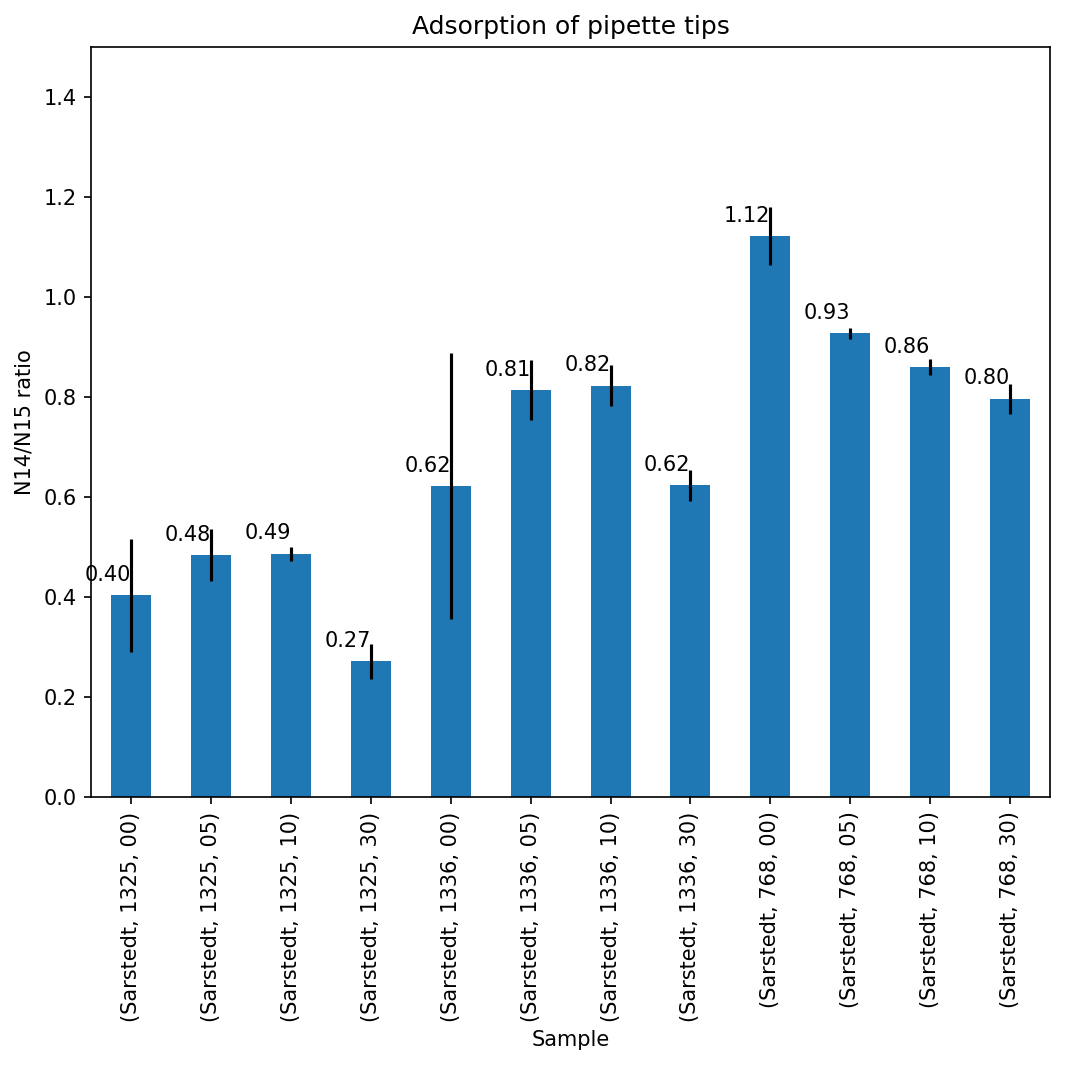

In [29]:
plt.rcParams["figure.figsize"] = (7.2,7.2)
# Plot the figure.
plt.figure()
ax = ratios_way2.groupby(["Tip brand","peak","# of tips",]).mean().plot(kind='bar',
                                                 logy=False,
                                                yerr=ratios_way2.groupby(["Tip brand","peak","# of tips",]).sem(),
                                                legend=False
                                                )
ax.set_title('Adsorption of pipette tips')
ax.set_xlabel('Sample')
ax.set_ylabel('N14/N15 ratio')
#ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='right',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.ylim(0,1.5) #manually adjust y axis 
plt.tight_layout()
plt.savefig("ratios_labeled.svg") #save plot

The above plot is a bit messy and also, while it is good to see the ratios (too high or too low ratios would not be particularly trustworthy), concentration is what we are really after so below I convert the ratios to concentrations. In this case I spiked the N14 samples with a final conc of 2.61 µM N15 labeled $A{\beta}_{m1-42}$, but this spiking also diluted the sample a bit so to get the initial N14 concentration, $c_{N14}$ I calculate in the following way:
$$c_{N14} = \frac{\sum(I_{N14})}{\sum(I_{N15})}*c_{N15}*\frac{V_2}{V_1}$$

Where $I_{N14}$ and $I_{N15}$ are the peak intensities of the N14 and N15 peaks respectively, $c_{N15}$ is the N15 concentration after spiking and $V_2$ and $V_1$ are the total volumes after and before the spiking respectively. For this particular case the volumes were 115 and 100 µl so to convert my ratios to concentrations I have to multiply them with $2.61*1.15=3$.

In [20]:
conc_way2 = ratios_way2 * 3
conc_way2

Ratio
Tip brand # of tips rep peak          
Sarstedt  00        1   768   3.065488
                        1325  0.663068
                        1336  0.466338
                    2   768   3.361925
                        1325  1.134385
                        1336  1.895187
                    3   768   3.664137
                        1325  1.829176
                        1336  3.226011
          10        1   768   2.524163
                        1325  1.493750
                        1336  2.566979
                    2   768   2.674669
                        1325  1.374778
                        1336  2.218913
                    3   768   2.533651
                        1325  1.502245
                        1336  2.611979
          30        1   768   2.562975
                        1325  1.019353
                        1336  1.818851
                    2   768   2.258159
                        1325  0.664222
                        1336  2.047115
                    3   768   2.340455
                        1325  0.755199
                        1336  1.736714
          05        1   768   2.824373
                        1325  1.138244
                        1336  2.242920
                    2   768   2.715604
                        1325  1.577948
                        1336  2.278417
                    3   768   2.796513
                        1325  1.628048
                        1336  2.797903

To sort the values appropriately we can play around with the expression below.

In [21]:
conc_way2.filter(like='768',axis=0).groupby(["# of tips"]).mean()

,Ratio
# of tips,
00,3.363850
05,2.778830
10,2.577494
30,2.387196


Now we plot the generated concentrations using the above expression (not automatically though) in a composite plot with individual bar plots for each of the 3 digestion products. Error bars are s.e.m.

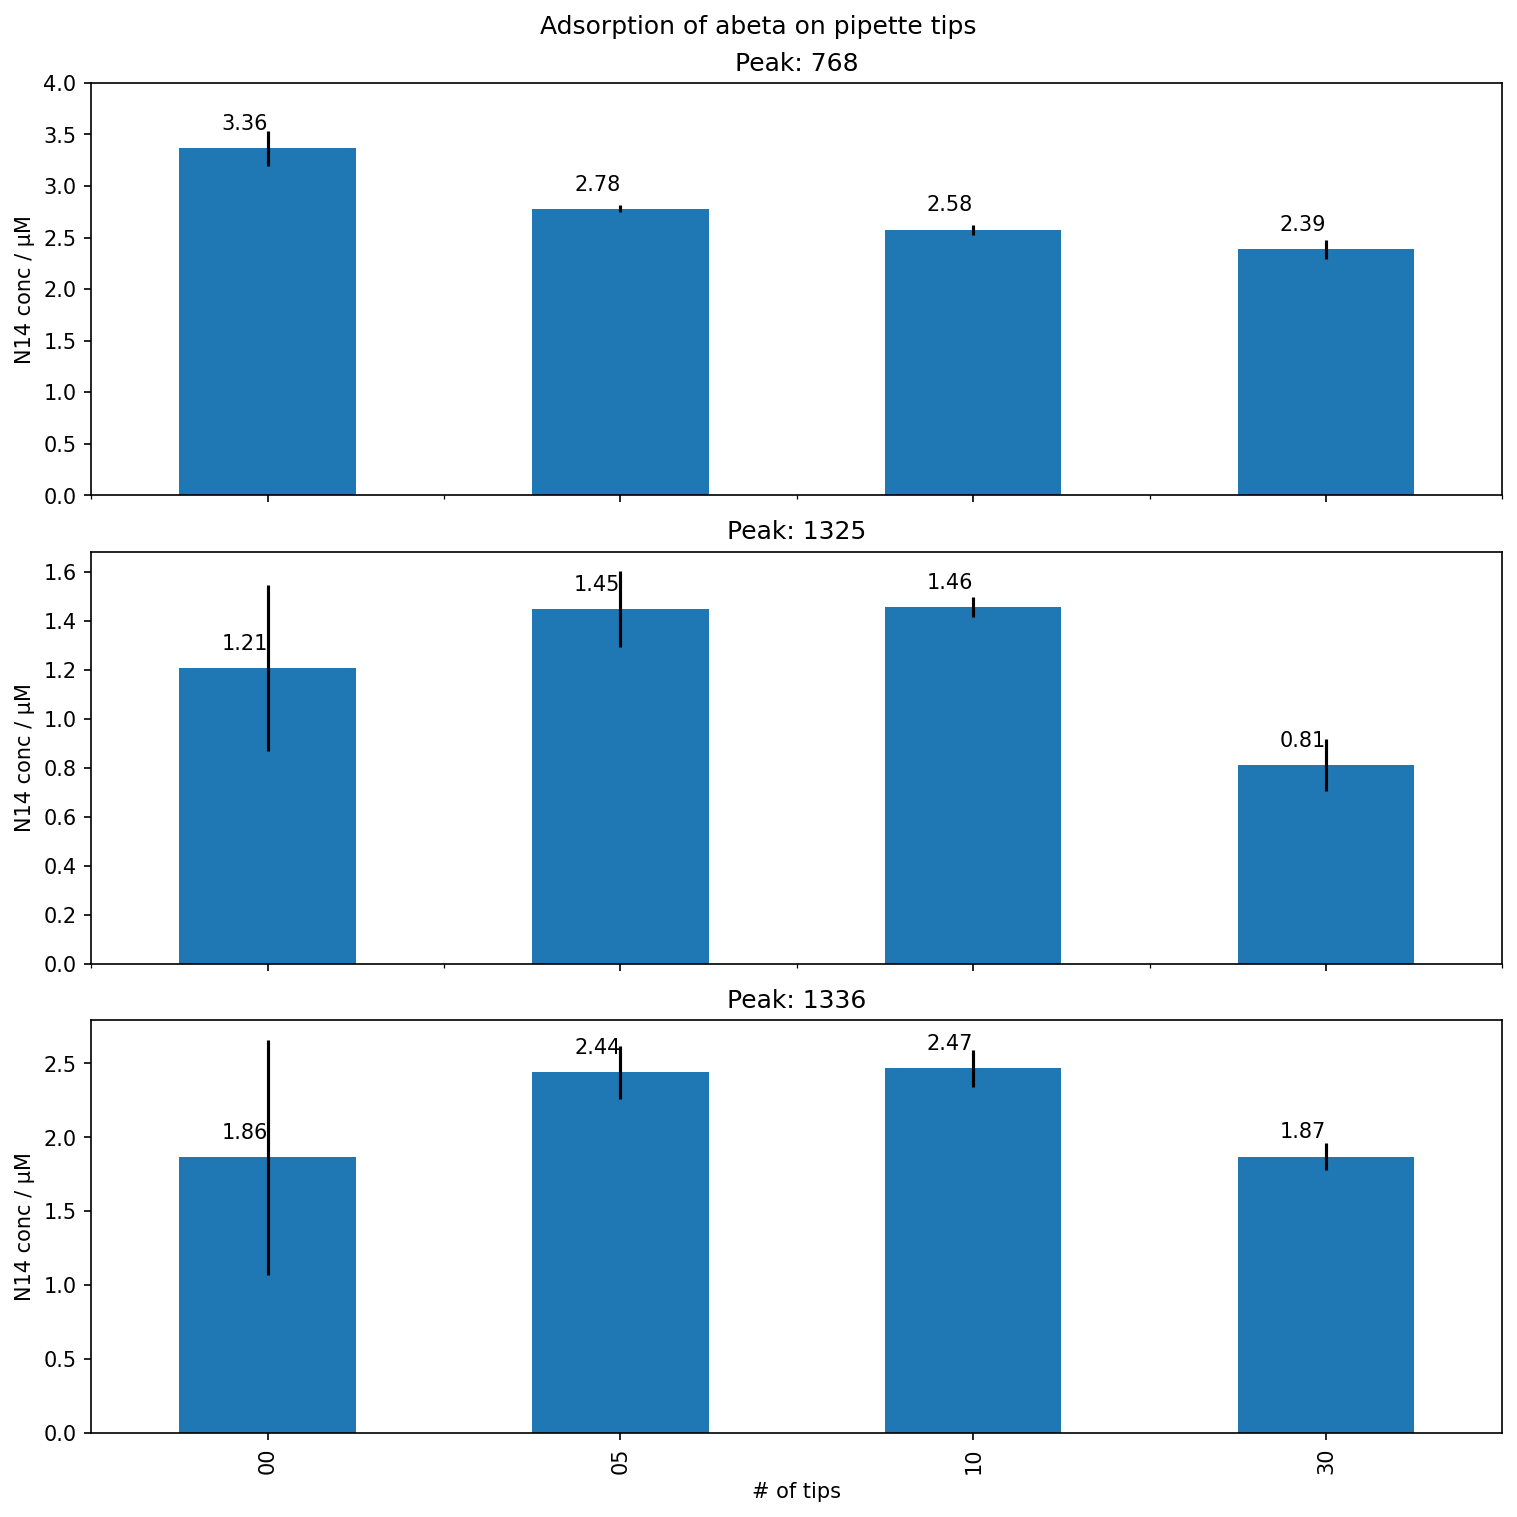

In [31]:
plt.rcParams["figure.figsize"] = (3.5,7.2)
layout ="""
A
B
C
"""
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(layout)
peaknames=['768','1325','1336']
fig.suptitle('Adsorption of abeta on pipette tips')
conc_way2.filter(like=peaknames[0],axis=0).groupby(["# of tips"]).mean().plot(kind='bar',
                             logy=False,
                            yerr=conc_way2.filter(like=peaknames[0],axis=0).groupby(["# of tips"]).sem(),
                            legend=False, ax=ax_dict['A'], ylim=(0,4), figsize=(10,10), title=('Peak: ' + peaknames[0]),
                            sharex=True, ylabel='N14 conc / µM'
                            )
conc_way2.filter(like=peaknames[1],axis=0).groupby(["# of tips"]).mean().plot(kind='bar',
                             logy=False,
                            yerr=conc_way2.filter(like=peaknames[1],axis=0).groupby(["# of tips"]).sem(),
                            legend=False, ax=ax_dict['B'], title=('Peak: ' + peaknames[1]), ylabel='N14 conc / µM'
                            )
conc_way2.filter(like=peaknames[2],axis=0).groupby(["# of tips"]).mean().plot(kind='bar',
                             logy=False,
                            yerr=conc_way2.filter(like=peaknames[2],axis=0).groupby(["# of tips"]).sem(),
                            legend=False, ax=ax_dict['C'], title=('Peak: ' + peaknames[2]), ylabel='N14 conc / µM'
                            )
add_value_labels(ax_dict['A'],7)
add_value_labels(ax_dict['B'],7)
add_value_labels(ax_dict['C'],7)
plt.savefig("conc_labeled_composite.svg")
plt.savefig("conc_labeled_composite.pdf")

## Done! 